Test CNN on spectrogram

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import time
import numpy as np
import torch.utils.data as data_utils
import torch.nn.functional as F

from scipy import signal
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

Organize data into something useable

In [10]:
def split_train_test_kfold(k_fold=1):
    features_og = np.load('features_nonsliding_ch.npy')
    targets_og = np.load('targets_nonsliding_ch.npy')
    print(sum(targets_og),targets_og.shape)

    # Split data into train and test
    split = np.arange(len(targets_og))
    np.random.shuffle(split)
    features_og = features_og[split]
    targets_og = targets_og[split]
    features_og_0 = features_og[np.where(targets_og==0)[0]]
    features_og_1 = features_og[np.where(targets_og==1)[0]]
    targets_og_0 = targets_og[np.where(targets_og==0)[0]]
    targets_og_1 = targets_og[np.where(targets_og==1)[0]]
    N_0 = len(targets_og_0)
    N_1 = len(targets_og_1)
    
    features_og_train = np.vstack([features_og_0,features_og_1])
    targets_og_train = np.vstack([targets_og_0,targets_og_1])
    sample_list = []
    for i in range(k_fold):
        if (i+1)==k_fold:
            temp1 = np.arange(i*N_0//k_fold,N_0, dtype=np.int64)
            temp2 = np.arange(i*N_1//k_fold,N_1, dtype=np.int64)+N_0
        else:
            temp1 = np.arange(i*N_0//k_fold,(i+1)*N_0//k_fold, dtype=np.int64)
            temp2 = np.arange(i*N_1//k_fold,(i+1)*N_1//k_fold, dtype=np.int64)+N_0
        temp2 = np.repeat(temp2,250)
        sample_list.append(np.hstack([temp1,temp2]))
    
    train_sampler_list = []
    test_sampler_list = []
    for i in range(k_fold):
        temp = np.where(np.arange(len(sample_list), dtype=np.int64) != i)[0]
        train =  np.hstack([sample_list[x] for x in temp])
        test = sample_list[i]
        train_sampler_list.append(SubsetRandomSampler(train))
        test_sampler_list.append(SubsetRandomSampler(test))
        
    # Convert data to tensor dataset
    features = torch.from_numpy(features_og_train).float()
    targets = torch.from_numpy(targets_og_train).long()
    targets = torch.squeeze(targets)
    train = data_utils.TensorDataset(features, targets)
    
    return train_sampler_list, test_sampler_list, train
    
def split_train_test(train_percent, k_fold=0):
    features_og = np.load('features_nonsliding_ch.npy')
    targets_og = np.load('targets_nonsliding_ch.npy')
    print(sum(targets_og),targets_og.shape)

    # Split data into train and test
    split = np.arange(len(targets_og))
    np.random.shuffle(split)
    features_og = features_og[split]
    targets_og = targets_og[split]
    features_og_0 = features_og[np.where(targets_og==0)[0]]
    features_og_1 = features_og[np.where(targets_og==1)[0]]
    targets_og_0 = targets_og[np.where(targets_og==0)[0]]
    targets_og_1 = targets_og[np.where(targets_og==1)[0]]
    N_0 = len(targets_og_0)
    N_1 = len(targets_og_1)
    
    features_og_train = np.vstack([features_og_0[:int(train_percent*N_0)],features_og_1[:int(train_percent*N_1)]])
    targets_og_train = np.vstack([targets_og_0[:int(train_percent*N_0)],targets_og_1[:int(train_percent*N_1)]])
    features_og_test = np.vstack([features_og_0[int(train_percent*N_0):],features_og_1[int(train_percent*N_1):]])
    targets_og_test = np.vstack([targets_og_0[int(train_percent*N_0):],targets_og_1[int(train_percent*N_1):]])
    print(sum(targets_og_train), sum(targets_og_test))
    

    # Balance dataset
    # ~1/4000 seizure events
    idx = np.hstack([np.where(targets_og_train == 0)[0], 
                     np.repeat(np.where(targets_og_train == 1)[0], 100)]) # Oversample
    features = features_og_train[idx]
    targets = targets_og_train[idx]

    # Convert data to tensor dataset
    features = torch.from_numpy(features).float()
    targets = torch.from_numpy(targets).long()
    targets = torch.squeeze(targets)
    train = data_utils.TensorDataset(features, targets)

    N = features.size()[0]
    sample_list = np.arange(N, dtype=np.int64)
    np.random.shuffle(sample_list)
    percent_train = 1.0

    #Training
    n_training_samples = int(N*percent_train)
    train_sampler = SubsetRandomSampler(sample_list[:n_training_samples])

    #Validation
    val_sampler = SubsetRandomSampler(sample_list[:n_training_samples])

    #Test data
    features = torch.from_numpy(features_og_test).float()
    targets = torch.from_numpy(targets_og_test).long()
    targets = torch.squeeze(targets)
    test = data_utils.TensorDataset(features, targets)
    return train, test, train_sampler, val_sampler

In [5]:
class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(23, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 16 *16)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [15]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size, train_sampler):
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
    return(train_loader)

#Test and validation loaders have constant batch sizes, so we can define them directly

def trainNet(net, train_sampler, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size, train_sampler)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.6f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data[0]
            
        print("Validation loss = {:.2f}".format(total_val_loss / max(1,len(val_loader))))
        

        print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
        
def calculate_cm(test_sampler):
    test_loader = torch.utils.data.DataLoader(train, sampler=test_sampler, batch_size=2)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data          
            outputs = CNN(images)
            _, predicted = torch.max(outputs.data, 1)
            for x,y in zip(predicted, labels):
                y_true.append(int(y.numpy()))
                y_pred.append(int(x.numpy()))
    return confusion_matrix(np.array(y_true), np.array(y_pred))

In [26]:
# Split data
train, test, train_sampler, val_sampler = split_train_test(0.85)
# Build and train CNN
CNN = SimpleCNN()
trainNet(CNN, batch_size=4, n_epochs=25, learning_rate=1e-7)#1e-6, 10

===== HYPERPARAMETERS =====
batch_size= 4
epochs= 20
learning_rate= 1e-07


/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 10% 	 train_loss: 2.583366 took: 1.68s
Epoch 1, 20% 	 train_loss: 1.967699 took: 1.16s
Epoch 1, 30% 	 train_loss: 1.458107 took: 1.18s
Epoch 1, 40% 	 train_loss: 1.249286 took: 1.29s
Epoch 1, 50% 	 train_loss: 1.024508 took: 1.16s
Epoch 1, 60% 	 train_loss: 0.951950 took: 1.19s
Epoch 1, 70% 	 train_loss: 0.825036 took: 1.14s
Epoch 1, 80% 	 train_loss: 0.809808 took: 1.23s
Epoch 1, 90% 	 train_loss: 0.701772 took: 1.13s


/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss = 0.63
Epoch 2, 10% 	 train_loss: 0.594906 took: 1.77s
Epoch 2, 20% 	 train_loss: 0.599846 took: 1.16s
Epoch 2, 30% 	 train_loss: 0.531406 took: 1.39s
Epoch 2, 40% 	 train_loss: 0.535186 took: 1.17s
Epoch 2, 50% 	 train_loss: 0.511298 took: 1.21s
Epoch 2, 60% 	 train_loss: 0.462963 took: 1.21s
Epoch 2, 70% 	 train_loss: 0.439777 took: 1.20s
Epoch 2, 80% 	 train_loss: 0.380659 took: 1.18s
Epoch 2, 90% 	 train_loss: 0.389825 took: 1.24s
Validation loss = 0.37
Epoch 3, 10% 	 train_loss: 0.362626 took: 1.73s
Epoch 3, 20% 	 train_loss: 0.326635 took: 1.37s
Epoch 3, 30% 	 train_loss: 0.323807 took: 1.18s
Epoch 3, 40% 	 train_loss: 0.303603 took: 1.33s
Epoch 3, 50% 	 train_loss: 0.317406 took: 1.17s
Epoch 3, 60% 	 train_loss: 0.300134 took: 1.19s
Epoch 3, 70% 	 train_loss: 0.258814 took: 1.27s
Epoch 3, 80% 	 train_loss: 0.262742 took: 1.30s
Epoch 3, 90% 	 train_loss: 0.254640 took: 1.21s
Validation loss = 0.23
Epoch 4, 10% 	 train_loss: 0.236902 took: 1.84s
Epoch 4, 20% 	 trai

Epoch 19, 90% 	 train_loss: 0.007176 took: 1.22s
Validation loss = 0.01
Epoch 20, 10% 	 train_loss: 0.005668 took: 1.87s
Epoch 20, 20% 	 train_loss: 0.008720 took: 1.33s
Epoch 20, 30% 	 train_loss: 0.006293 took: 1.19s
Epoch 20, 40% 	 train_loss: 0.004814 took: 1.28s
Epoch 20, 50% 	 train_loss: 0.006440 took: 1.23s
Epoch 20, 60% 	 train_loss: 0.006062 took: 1.19s
Epoch 20, 70% 	 train_loss: 0.004907 took: 1.23s
Epoch 20, 80% 	 train_loss: 0.005867 took: 1.27s
Epoch 20, 90% 	 train_loss: 0.004979 took: 1.16s
Validation loss = 0.01
Training finished, took 328.44s


In [21]:
# cross validation
k_fold = 10
train_sampler_list, test_sampler_list, train = split_train_test_kfold(k_fold=k_fold)

cm = np.zeros((2,2))
for train_sampler, test_sampler in zip(train_sampler_list, test_sampler_list):
    CNN = SimpleCNN()
    val_loader = torch.utils.data.DataLoader(train, batch_size=32, sampler=train_sampler, num_workers=2)
    trainNet(CNN, train_sampler, batch_size=1, n_epochs=10, learning_rate=1e-6)# 2,5,1e-6 
    cm += calculate_cm(test_sampler)
    print(cm)

tn, fp, fn, tp = cm.ravel()
fn=fn/250
tp=tp/250
acc = (tp+tn)/(tn+fp+fn+tp)
sen = tp/(tp+fn)
spec = tn/(tn+fp)
prec = tp/(tp+fp)
F1 = 2 * (prec * sen) / (prec + sen)

print(cm)
print('accuracy: ',acc)
print('sensitivity:', sen)
print('specificity:', spec)
print('precision:', prec)
print('F1:', F1)

[ 38.] (10379, 1)
===== HYPERPARAMETERS =====
batch_size= 1
epochs= 10
learning_rate= 1e-06


/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 10% 	 train_loss: 0.686015 took: 5.78s
Epoch 1, 20% 	 train_loss: 0.114861 took: 5.88s
Epoch 1, 30% 	 train_loss: 0.058533 took: 5.56s
Epoch 1, 40% 	 train_loss: 0.029541 took: 5.83s
Epoch 1, 50% 	 train_loss: 0.023492 took: 5.63s
Epoch 1, 60% 	 train_loss: 0.012049 took: 5.61s
Epoch 1, 70% 	 train_loss: 0.008899 took: 5.72s
Epoch 1, 80% 	 train_loss: 0.008658 took: 5.79s
Epoch 1, 90% 	 train_loss: 0.006027 took: 5.72s


/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss = 0.00
Training finished, took 61.95s
Epoch 2, 10% 	 train_loss: 0.002458 took: 5.88s
Epoch 2, 20% 	 train_loss: 0.002033 took: 5.74s
Epoch 2, 30% 	 train_loss: 0.002376 took: 5.80s
Epoch 2, 40% 	 train_loss: 0.004191 took: 5.90s
Epoch 2, 50% 	 train_loss: 0.004939 took: 5.88s
Epoch 2, 60% 	 train_loss: 0.002037 took: 5.92s
Epoch 2, 70% 	 train_loss: 0.002337 took: 6.43s
Epoch 2, 80% 	 train_loss: 0.000962 took: 5.90s
Epoch 2, 90% 	 train_loss: 0.001844 took: 5.93s
Validation loss = 0.00
Training finished, took 125.61s
Epoch 3, 10% 	 train_loss: 0.000450 took: 6.14s
Epoch 3, 20% 	 train_loss: 0.002563 took: 5.64s
Epoch 3, 30% 	 train_loss: 0.002017 took: 5.76s
Epoch 3, 40% 	 train_loss: 0.000929 took: 5.67s
Epoch 3, 50% 	 train_loss: 0.000416 took: 5.66s
Epoch 3, 60% 	 train_loss: 0.000338 took: 5.72s
Epoch 3, 70% 	 train_loss: 0.000307 took: 5.73s
Epoch 3, 80% 	 train_loss: 0.000714 took: 5.88s
Epoch 3, 90% 	 train_loss: 0.000254 took: 5.79s
Validation loss = 0.00
Trai

Epoch 8, 60% 	 train_loss: 0.000001 took: 6.21s
Epoch 8, 70% 	 train_loss: 0.000001 took: 6.32s
Epoch 8, 80% 	 train_loss: 0.000001 took: 6.24s
Epoch 8, 90% 	 train_loss: 0.000005 took: 6.08s
Validation loss = 0.00
Training finished, took 510.09s
Epoch 9, 10% 	 train_loss: 0.000000 took: 6.14s
Epoch 9, 20% 	 train_loss: 0.000001 took: 5.94s
Epoch 9, 30% 	 train_loss: 0.000000 took: 5.99s
Epoch 9, 40% 	 train_loss: 0.000000 took: 5.98s
Epoch 9, 50% 	 train_loss: 0.000000 took: 5.98s
Epoch 9, 60% 	 train_loss: 0.000001 took: 5.99s
Epoch 9, 70% 	 train_loss: 0.000000 took: 6.00s
Epoch 9, 80% 	 train_loss: 0.000000 took: 5.91s
Epoch 9, 90% 	 train_loss: 0.000001 took: 5.91s
Validation loss = 0.00
Training finished, took 574.29s
Epoch 10, 10% 	 train_loss: 0.000000 took: 6.15s
Epoch 10, 20% 	 train_loss: 0.000000 took: 5.77s
Epoch 10, 30% 	 train_loss: 0.000000 took: 5.79s
Epoch 10, 40% 	 train_loss: 0.000000 took: 5.95s
Epoch 10, 50% 	 train_loss: 0.000000 took: 5.92s
Epoch 10, 60% 	 train

Epoch 4, 70% 	 train_loss: 0.000363 took: 5.67s
Epoch 4, 80% 	 train_loss: 0.000182 took: 5.95s
Epoch 4, 90% 	 train_loss: 0.000112 took: 6.12s
Validation loss = 0.00
Training finished, took 251.40s
Epoch 5, 10% 	 train_loss: 0.000109 took: 5.77s
Epoch 5, 20% 	 train_loss: 0.000094 took: 5.57s
Epoch 5, 30% 	 train_loss: 0.000096 took: 5.78s
Epoch 5, 40% 	 train_loss: 0.000099 took: 5.66s
Epoch 5, 50% 	 train_loss: 0.000051 took: 5.72s
Epoch 5, 60% 	 train_loss: 0.000082 took: 5.64s
Epoch 5, 70% 	 train_loss: 0.001114 took: 5.74s
Epoch 5, 80% 	 train_loss: 0.000075 took: 5.75s
Epoch 5, 90% 	 train_loss: 0.000043 took: 5.64s
Validation loss = 0.00
Training finished, took 313.03s
Epoch 6, 10% 	 train_loss: 0.000023 took: 6.31s
Epoch 6, 20% 	 train_loss: 0.000108 took: 5.89s
Epoch 6, 30% 	 train_loss: 0.000029 took: 6.23s
Epoch 6, 40% 	 train_loss: 0.000039 took: 5.96s
Epoch 6, 50% 	 train_loss: 0.000027 took: 5.89s
Epoch 6, 60% 	 train_loss: 0.000020 took: 5.91s
Epoch 6, 70% 	 train_loss:

Process Process-1074:
Process Process-1073:
Traceback (most recent call last):
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/to

Traceback (most recent call last):
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-8b7d5270fc24>", line 9, in <module>
    trainNet(CNN, train_sampler, batch_size=1, n_epochs=10, learning_rate=1e-6)# 2,5,1e-6
  File "<ipython-input-15-77bffaf0699d>", line 37, in trainNet
    for i, data in enumerate(train_loader, 0):
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/home/Christian/anaconda2/envs/py36/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/Christian/anaconda2/envs/py36/lib/python

KeyboardInterrupt: 

In [20]:
tn, fp, fn, tp = cm.ravel()
fn=fn/250
tp=tp/250
acc = (tp+tn)/(tn+fp+fn+tp)
sen = tp/(tp+fn)
spec = tn/(tn+fp)
prec = tp/(tp+fp)
F1 = 2 * (prec * sen) / (prec + sen)

print(cm)
print('accuracy: ',acc)
print('sensitivity:', sen)
print('specificity:', spec)
print('precision:', prec)
print('F1:', F1)

[[  1.03390000e+04   2.00000000e+00]
 [  2.25000000e+03   7.25000000e+03]]
accuracy:  0.998940167646
sensitivity: 0.763157894737
specificity: 0.999806595107
precision: 0.935483870968
F1: 0.840579710145


In [29]:
cm = confusion_matrix(np.array(y_true), np.array(y_pred))
    
test_loader = torch.utils.data.DataLoader(test, batch_size=2)
cm = np.zeros((2,2))
total=0
correct=0
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data          
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for x,y in zip(predicted, labels):
            y_true.append(int(y.numpy()))
            y_pred.append(int(x.numpy()))
            
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

cm = confusion_matrix(np.array(y_true), np.array(y_pred))
tn, fp, fn, tp = cm.ravel()
acc = (tp+tn)/(tn+fp+fn+tp)
sen = tp/(tp+fn)
spec = tn/(tn+fp)
prec = tp/(tp+fp)
F1 = 2 * (prec * sen) / (prec + sen)

print(cm)
print('accuracy: ',acc)
print('sensitivity:', sen)
print('specificity:', spec)
print('precision:', prec)
print('F1:', F1)

Accuracy of the network on the 10000 test images: 99 %
[[1551    1]
 [   2    4]]
accuracy:  0.998074454429
sensitivity: 0.666666666667
specificity: 0.999355670103
precision: 0.8
F1: 0.727272727273


In [26]:
max(y_pred)

8

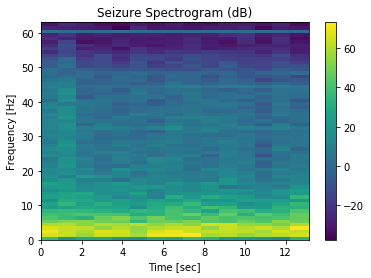

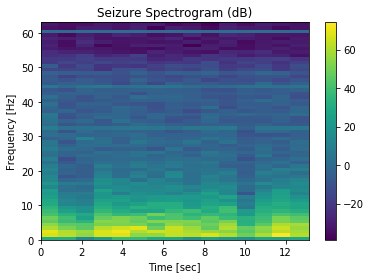

In [9]:
limit = 10e10
for i, data in enumerate(test_loader):
    if i > limit:
        break
    images, labels = data
    for x,y in zip(images,labels):
        x = x.numpy()
        y = y.numpy()
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.numpy()[0]
        if y==1:
            x=np.mean(x,axis=0)

            plt.pcolormesh(np.arange(x.shape[1])*0.875,np.arange(x.shape[0]),x)
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.colorbar()
            if y:
                plt.title('Seizure Spectrogram (dB)')
            else:
                plt.title('Normal Spectrogram (dB)')
            plt.show()